In [1]:
import os
import tarfile
import joblib

import numpy as np
import pandas as pd
from scipy.stats import randint
from six.moves import urllib
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    train_test_split,
)
from sklearn.tree import DecisionTreeRegressor

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


fetch_housing_data()
housing = load_housing_data()

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# Train and Test split of the data
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# Creating income category so that stratified sampling can be done
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


<AxesSubplot: >

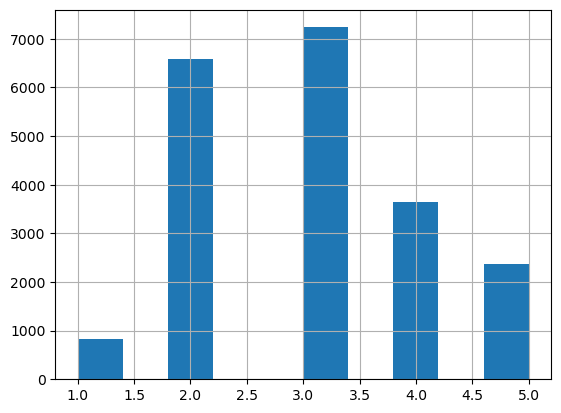

In [6]:
housing['income_cat'].hist()

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


In [8]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN,3
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN,3
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN,3
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN,2
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND,3


In [9]:
compare_props = pd.DataFrame(
    {
        "Overall": income_cat_proportions(housing),
        "Stratified": income_cat_proportions(strat_test_set),
        "Random": income_cat_proportions(test_set),
    }
).sort_index()
compare_props["Rand. %error"] = (
    100 * compare_props["Random"] / compare_props["Overall"] - 100
)
compare_props["Strat. %error"] = (
    100 * compare_props["Stratified"] / compare_props["Overall"] - 100
)

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

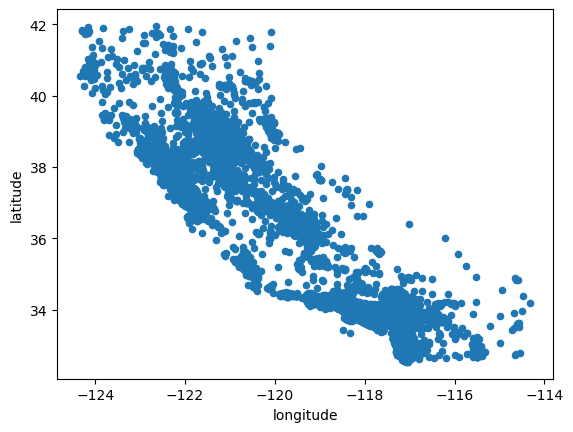

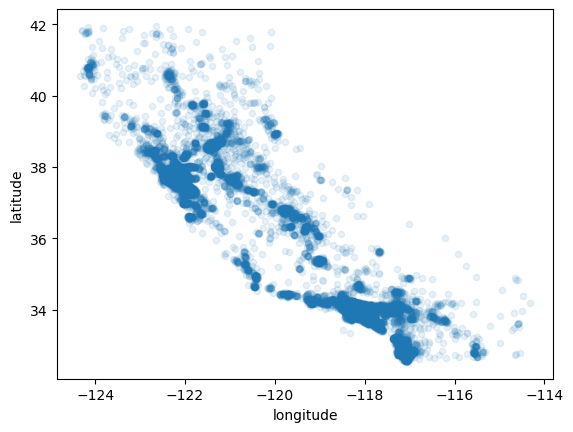

In [10]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

In [11]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = (
    housing["total_bedrooms"] / housing["total_rooms"]
)
housing["population_per_household"] = (
    housing["population"] / housing["households"]
)

housing = strat_train_set.drop(
    "median_house_value", axis=1
)  # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
housing_tr["rooms_per_household"] = (
    housing_tr["total_rooms"] / housing_tr["households"]
)
housing_tr["bedrooms_per_room"] = (
    housing_tr["total_bedrooms"] / housing_tr["total_rooms"]
)
housing_tr["population_per_household"] = (
    housing_tr["population"] / housing_tr["households"]
)

housing_cat = housing[["ocean_proximity"]]
housing_prepared = housing_tr.join(
    pd.get_dummies(housing_cat, drop_first=True)
)

/tmp/ipykernel_2552/1493812619.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [12]:
housing_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,5.485836,0.205784,3.168555,1,0,0,0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,6.927083,0.160714,2.623698,0,0,0,1
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,5.393333,0.191595,2.223333,1,0,0,0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,3.886128,0.276505,1.859213,0,0,0,1
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,6.096552,0.182692,3.167241,0,0,0,0


### Exercise 2

Use Randomized Search CV for the SVR algorithm

In [13]:
from scipy.stats import expon, reciprocal

param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20,20000),
    'gamma': expon(scale=1.0)
}

In [14]:
rand_search_path = "datasets/artifacts/rand_search_svm_result.pkl"

In [15]:
if not os.path.exists(rand_search_path):
    svm_regressor = SVR()
    rand_search = RandomizedSearchCV(svm_regressor,
                                    param_distribs,
                                    n_iter=8,
                                    cv=2,
                                    scoring='neg_mean_squared_error',
                                    verbose=2,
                                    n_jobs=-1,
                                    random_state=42)

    rand_search.fit(housing_prepared, housing_labels)

    joblib.dump(rand_search, "datasets/artifacts/rand_search_svm_result.pkl")

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END C=58.750769152656574, gamma=0.059838768608680676, kernel=rbf; total time=  19.2s
[CV] END C=4366.193678104918, gamma=0.9084469696321253, kernel=rbf; total time=  20.1s
[CV] END C=4366.193678104918, gamma=0.9084469696321253, kernel=rbf; total time=  20.2s
[CV] END C=58.750769152656574, gamma=0.059838768608680676, kernel=rbf; total time=  21.4s
[CV] END C=23.055974256464793, gamma=3.503557475158312, kernel=rbf; total time=  18.8s
[CV] END C=23.055974256464793, gamma=3.503557475158312, kernel=rbf; total time=  19.8s
[CV] END C=13082.421055385465, gamma=0.0007790692366582295, kernel=rbf; total time=  20.3s
[CV] END C=13082.421055385465, gamma=0.0007790692366582295, kernel=rbf; total time=  20.8s
[CV] END C=70.99757664393003, gamma=0.3627537294604771, kernel=rbf; total time=  20.7s
[CV] END C=70.99757664393003, gamma=0.3627537294604771, kernel=rbf; total time=  20.8s
[CV] END C=21.000465008462697, gamma=0.02333252359832338

RandomizedSearchCV(cv=2, estimator=SVR(), n_iter=8, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f434f5da340>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f434f613fd0>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [15]:
rand_search = joblib.load(rand_search_path)

In [16]:
negative_mse_rnd = rand_search.best_score_
rmse_rnd = np.sqrt(-negative_mse_rnd)
rmse_rnd

70874.98448995409

In [17]:
rand_search.best_params_

{'C': 265.8583788632432, 'gamma': 3.010121430917521, 'kernel': 'linear'}

### Exercise 3

Try adding a transformer in the preparation pipeline to select only most imoportant features

In [18]:
# Recurssive Feature Elimination with CV using Randome Forest Regressor
from sklearn.feature_selection import RFECV

k_features = 5
reg_rf =  RandomForestRegressor(random_state=42)
rfecv = RFECV(
    estimator=reg_rf,
    step=1,
    cv=3,
    n_jobs=-1,
    min_features_to_select=k_features,
    verbose=2,
    importance_getter='feature_importances_'
)

rfecv.fit(housing_prepared, housing_labels)

Fitting estimator with 15 features.
Fitting estimator with 15 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 9 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 8 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 7 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fi

RFECV(cv=3, estimator=RandomForestRegressor(random_state=42),
      importance_getter='feature_importances_', min_features_to_select=5,
      n_jobs=-1, verbose=2)

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

# Custom Transformer for Feature Selection
class featureSelectorRFE(BaseEstimator, TransformerMixin):

    # Initiating the class feature selector with two attributes
    def __init__(self,
                 rfecv,
                 k_features_limit = None) -> None:
        super().__init__()
        self.rfecv = rfecv
        self.support_ = self.rfecv.support_
        self.feature_importances_ = self.rfecv.estimator_.feature_importances_
        self.n_features_ = self.rfecv.n_features_
        self.k_features_limit = k_features_limit

    def fit(self, X, y=None):
        return self
    
    # Getting the important features and its index using rfecv object
    def transform(self, X):
        # self.fit(X, y)
        self.features_used_index = [i for i,x in enumerate(self.support_) if x]
        arr = self.feature_importances_
        if self.k_features_limit == None:
            k = self.n_features_
        else:
            k = self.k_features_limit
        top_k_indices = np.sort(np.argpartition(np.array(arr), -k)[-k:]).tolist()
        indices = [self.features_used_index[i] for i in top_k_indices]
        return X[:, indices]


<b> Used recurvsive feature elimination with sk learn, and custom transformere is based on the recursive feature elimination

In [33]:
# Custom Transformer
col_names = "total_rooms", "total_bedrooms", "population", "households"

rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names
]

class addAttributes(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, 
                     rooms_per_household,
                     population_per_household,
                     bedrooms_per_room] 


In [34]:
# Numeric Transformer Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', addAttributes()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)


In [35]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [50]:
rfecv_support_ = rfecv.support_
rfecv_feature_importances_ = rfecv.estimator_.feature_importances_
rfecv_n_features_ = rfecv.n_features_

preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', featureSelectorRFE(
        rfecv,
        k_features
    ))
])

housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing, housing_labels)

In [51]:
housing_prepared_top_k_features

array([[-0.94135046,  1.34743822, -0.8936472 , -0.12112176,  0.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.81086696,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.33827252,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828, -0.36547546,  0.32286937,  1.        ],
       [-1.56080303,  1.2492109 ,  0.16826095, -0.45702273,  1.        ],
       [-1.28105026,  2.02567448, -0.390569  , -0.12169672,  0.        ]])

In [52]:
preparation_and_feature_selection_pipeline

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   addAttributes()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat', OneHotEncoder(),
                                                  ['ocean_proximity'])])),
                ('feature_selection',
                 featureSelectorRFE(k_features_limit=5,
                                    rfecv=RFECV(cv=3,
                                                estimator=RandomForestRegressor(random_state=42),
                                                importance_getter='feature_importances_',
                                                min_features_to_select=5,
                                                n_jobs=-1, verbose=2)))])

### Exercise 4
Try creating a single pipeline that does the full data preparation and final prediction

In [53]:
single_pipeline = Pipeline(
    [
    ('data_preparation', full_pipeline),
    ('feature_selection', featureSelectorRFE(
        rfecv,
        k_features
    )),
    ('svm_reg', SVR(**rand_search.best_params_))
    ]
)

In [54]:
single_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('data_preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   addAttributes()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat', OneHotEncoder(),
                                                  ['o...
                 featureSelectorRFE2(k_features_limit=5,
                                     rfecv_feature_importances_=array([0.07131372, 0.06885674, 0.05270879, 0.48359956, 0.04834116,
       0.13508128, 0.14009875]),
                                     rfecv_n_features_=7,
                                     rfecv_support_=array([ True,  True,  True, False, False, False, False,  True,  True,
       False,  True,  True, False, False, False]))),
                ('svm_reg',
                 SVR(C=265.8583788632432, gamma=3.010121430917521,
                     kernel='linear'))])

In [55]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", single_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 88218.51601187 274090.86113362 124864.29693436 133459.82323953]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0]


### Exercise 5

Explore other comibnations in Grid Search for the whole pipeline

In [66]:
full_pipeline.named_transformers_["cat"].handle_unknown = 'ignore'

param_grid = [{
    'data_preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k_features_limit': list(range(3, rfecv_n_features_ + 1))    
}]

grid_search_prep = GridSearchCV(single_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=3; total time=   5.1s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=3; total time=   5.9s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=3; total time=   5.7s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=3; total time=   5.6s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=3; total time=   5.5s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=4; total time=   5.0s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=4; total time=   5.6s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=4; total time=   5.8s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=4; total time=   5.8s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=4; total time=   5.5s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=5; total time=   4.9s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=5; total time=   5.5s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=5; total time=   5.5s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=5; total time=   5.5s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=5; total time=   5.5s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=6; total time=   4.9s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=6; total time=   5.5s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=6; total time=   5.5s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=6; total time=   5.6s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=6; total time=   5.5s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=7; total time=   4.8s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=7; total time=   5.5s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=7; total time=   5.5s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=7; total time=   5.5s
[CV] END data_preparation__num__imputer__strategy=mean, feature_selection__k_features_limit=7; total time=   5.5s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=3; total time=   4.9s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=3; total time=   5.6s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=3; total time=   5.6s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=3; total time=   5.5s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=3; total time=   5.5s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=4; total time=   4.9s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=4; total time=   5.5s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=4; total time=   5.6s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=4; total time=   5.6s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=4; total time=   5.5s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=5; total time=   5.1s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=5; total time=   5.9s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=5; total time=   5.8s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=5; total time=   5.9s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=5; total time=   5.9s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=6; total time=   5.1s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=6; total time=   5.8s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=6; total time=   5.7s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=6; total time=   5.8s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=6; total time=   5.8s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=7; total time=   5.4s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=7; total time=   6.3s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=7; total time=   5.8s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=7; total time=   5.6s
[CV] END data_preparation__num__imputer__strategy=median, feature_selection__k_features_limit=7; total time=   5.8s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=3; total time=   5.0s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=3; total time=   6.1s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=3; total time=   6.0s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=3; total time=   6.0s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=3; total time=   6.1s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=4; total time=   5.2s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=4; total time=   6.1s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=4; total time=   6.7s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=4; total time=   6.7s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=4; total time=   6.7s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=5; total time=   5.8s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=5; total time=   6.9s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=5; total time=   6.3s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=5; total time=   6.1s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=5; total time=   6.1s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=6; total time=   5.4s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=6; total time=   6.0s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=6; total time=   6.1s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=6; total time=   6.2s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=6; total time=   6.0s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 72, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/kus

[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=7; total time=   5.4s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=7; total time=   6.2s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=7; total time=   6.1s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=7; total time=   6.6s
[CV] END data_preparation__num__imputer__strategy=most_frequent, feature_selection__k_features_limit=7; total time=   6.1s


/home/kushalmiglani/miniconda3/envs/mle-dev/lib/python3.9/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          addAttributes()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
                                                                          'housing_median_age',
                                                                          'total_rooms',
                                                                          'total_bedrooms',
                                                                          'population',
                                                                          'households',
                                                                          'median_income']...
                                                            rfecv_support_=array([ True,  True,  True, False, False, False, False,  True,  True,
       False,  True,  True, False, False, False]))),
                                       ('svm_reg',
                                        SVR(C=265.8583788632432,
                                            gamma=3.010121430917521,
                                            kernel='linear'))]),
             param_grid=[{'data_preparation__num__imputer__strategy': ['mean',
                                                                       'median',
                                                                       'most_frequent'],
                          'feature_selection__k_features_limit': [3, 4, 5, 6,
                                                                  7]}],
             scoring='neg_mean_squared_error', verbose=2)

In [67]:
grid_search_prep.best_params_


{'data_preparation__num__imputer__strategy': 'mean',
 'feature_selection__k_features_limit': 3}